# Mix EMA & Couple candlesticks & Momentum - Strategy - Backtesting 

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)
# from backtesting import set_bokeh_output
# set_bokeh_output(notebook=False)

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-11-28 14:15:00,1306.1,1307.3,1305.6,1306.9,7726
2024-11-28 14:20:00,1306.9,1307.6,1306.0,1307.6,5086
2024-11-28 14:25:00,1307.6,1308.6,1307.4,1307.9,7291


In [6]:
def get_ema_signal(r):
    signal = ''
    if r['ema_fast_s1'] < r['ema_low_s1'] and r['ema_fast'] > r['ema_low']:
        signal = 'long'
    elif r['ema_fast_s1'] > r['ema_low_s1'] and r['ema_fast'] < r['ema_low']:
        signal = 'short'
    return signal

In [7]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond


def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] == r['Low'] and r['Low'] < r['low_s1']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] == r['High'] and r['High'] > r['high_s1']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond
    

def get_couple_candleticks_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [8]:
def cal_signal(row):
    signal = ''
    if not row['first_close']:
        return signal
    if row['Close'] - row['prev_low'] > 21 or row['prev_high'] - row['Close'] > 21:
        return signal
    if row['mom_y'] > 0.26 and row['body_rate'] > .65:
        signal = 'long'
    elif row['mom_y'] < -.18 and row['body_rate'] < -.39:
        signal = 'short'
    return signal


def cal_first_close(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 915]
    if not tick.empty:
        return tick[0]


def cal_high_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1345]
    return tick.max()


def cal_low_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1355]
    return tick.min()


def cal_last(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1445]
    if not tick.empty:
        return tick[0]

def cal_price(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1355]
    if not tick.empty:
        return tick[0]
        
def get_day_data(htd):
    data_tmp = htd.copy()
    data_tmp['first_close'] = data_tmp.Close
    data_tmp['_2pm_price'] = data_tmp.Close
    data_tmp['_last'] = data_tmp.Close
    data_tmp['prev_high'] = data_tmp.High
    data_tmp['prev_low'] = data_tmp.Low
    day_data = data_tmp.resample("D").agg({
        'first_close': cal_first_close,
        'prev_high': cal_high_before,
        'prev_low': cal_low_before,
        '_2pm_price': cal_price,
        '_last': cal_last
    }).rename(columns={'_last': 'day_Close'})
    day_data.dropna(subset=['day_Close'], inplace=True)
    day_data['prev_day_Close'] = day_data['day_Close'].shift(1)
    day_data.drop(columns=['day_Close'], inplace=True)
    return day_data[['prev_day_Close', 'first_close', 'prev_high', 'prev_low']]

def add_momentum_signal(data):
    clone_data = data.copy()
    day_data = get_day_data(clone_data)
    clone_data = clone_data.assign(time_d=pd.PeriodIndex(clone_data.index, freq='1D').to_timestamp())
    df_merged = pd.merge(clone_data, day_data, left_on="time_d", right_index=True, how="left")
    # df_merged = clone_data.merge(day_data, how='left', left_index=True, right_index=True)
    df_merged['mom_y'] = df_merged.apply(lambda r: 100 * (r['Close'] - r['prev_day_Close']) / r['prev_day_Close'] if r['first_close'] else 0, axis=1)
    df_merged['body_rate'] = df_merged.apply(lambda r: (r['Close'] - r['first_close']) / (r['prev_high'] - r['prev_low']) if r['first_close'] else 0, axis=1)
    df_merged['momentum_signal'] = df_merged.apply(lambda r: cal_signal(r), axis=1)
    df_merged.loc[100 * df_merged.index.hour + df_merged.index.minute != 1355, 'momentum_signal'] = ''
    return df_merged
    

In [9]:
def prepare_data(data):
    data["current"] = data.index + pd.DateOffset(minutes=5)
    # EMA signal
    data['max_in_range'] = data['High'].rolling(10).max()
    data['min_in_range'] = data['Low'].rolling(10).min()
    data["ema_fast"] = ta.ema(data["Close"], length=20)
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['ema_fast_s1'] = data['ema_fast'].shift(1)
    data['ema_low_s1'] = data['ema_low'].shift(1)
    data['ema_signal'] = data.apply(lambda r: get_ema_signal(r), axis=1)
    # Couple candlesticks signal
    data['low_s1'] = data['Low'].shift(1)
    data['high_s1'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['couple_cs_signal'] = data.apply(lambda r: get_couple_candleticks_signal(r), axis=1)
    # Momentum signal
    data = add_momentum_signal(data)
    # Optimnize
    data['RSI'] = ta.rsi(data["Close"], length=14)
    data['body'] = data.apply(lambda r: abs(r['Close'] - r['Open']), axis=1)
    data['ibs'] = data.apply(lambda x: (-10 if (x["High"] == x["Low"]) else 10 * (x["Close"] - x["Low"]) / (x["High"] - x["Low"])), axis=1)
    data["vol_20_mean"] = data["Volume"].rolling(20).mean()
    return data

In [10]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-11-28 14:15:00,1306.1,1307.3,1305.6,1306.9,7726
2024-11-28 14:20:00,1306.9,1307.6,1306.0,1307.6,5086
2024-11-28 14:25:00,1307.6,1308.6,1307.4,1307.9,7291


In [11]:
prepared_data = prepare_data(data)
prepared_data.dropna(subset=['Close'],inplace=True)

In [12]:
prepared_data

,Open,High,Low,Close,Volume,current,max_in_range,min_in_range,ema_fast,ema_low,...,first_close,prev_high,prev_low,mom_y,body_rate,momentum_signal,RSI,body,ibs,vol_20_mean
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910,2020-11-02 09:05:00,NaN,NaN,NaN,NaN,...,898.6,901.5,895.4,NaN,0.245902,,NaN,0.0,8.888889,NaN
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670,2020-11-02 09:10:00,NaN,NaN,NaN,NaN,...,898.6,901.5,895.4,NaN,0.131148,,NaN,0.8,4.666667,NaN
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329,2020-11-02 09:15:00,NaN,NaN,NaN,NaN,...,898.6,901.5,895.4,NaN,0.147541,,NaN,0.0,5.000000,NaN
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722,2020-11-02 09:20:00,NaN,NaN,NaN,NaN,...,898.6,901.5,895.4,NaN,0.000000,,NaN,0.8,3.076923,NaN
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939,2020-11-02 09:25:00,NaN,NaN,NaN,NaN,...,898.6,901.5,895.4,NaN,-0.065574,,NaN,0.3,8.095238,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-28 14:15:00,1306.1,1307.3,1305.6,1306.9,7726,2024-11-28 14:20:00,1311.1,1305.2,1309.318028,1302.830386,...,1316.5,1318.7,1308.2,-0.068818,-0.914286,,36.878302,0.8,7.647059,3759.80
2024-11-28 14:20:00,1306.9,1307.6,1306.0,1307.6,5086,2024-11-28 14:25:00,1311.1,1305.2,1309.154406,1302.868391,...,1316.5,1318.7,1308.2,-0.015293,-0.847619,,40.648838,0.7,10.000000,3891.45
2024-11-28 14:25:00,1307.6,1308.6,1307.4,1307.9,7291,2024-11-28 14:30:00,1311.1,1305.2,1309.034939,1302.908483,...,1316.5,1318.7,1308.2,0.007646,-0.819048,,42.241231,0.3,4.166667,4143.10


In [13]:
backtest_data = prepared_data[['Open', 'Close', 'High', 'Low', 'min_in_range', 'max_in_range', 'min_5', 'max_5', 'ema_signal', 'momentum_signal', 'couple_cs_signal']]
backtest_data[(backtest_data.ema_signal != '') | (backtest_data.momentum_signal != '') | (backtest_data.couple_cs_signal != '')]

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal
Date,,,,,,,,,,,
2020-11-02 10:05:00,900.0,899.5,900.4,899.5,896.5,901.4,897.7,901.4,,,short
2020-11-02 14:25:00,904.9,907.0,907.0,904.5,896.6,907.0,896.6,907.0,,,long
2020-11-03 09:20:00,908.5,908.1,908.8,908.1,897.4,909.4,908.1,909.4,,,short
2020-11-04 09:35:00,907.8,907.3,908.0,907.3,907.3,909.9,907.3,908.8,,,short
2020-11-04 10:05:00,908.2,909.0,909.0,908.1,906.7,909.0,906.8,909.0,,,long
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-28 10:10:00,1316.8,1316.1,1316.8,1316.1,1315.8,1318.5,1316.1,1318.5,,,short
2024-11-28 10:30:00,1314.8,1313.7,1314.9,1313.7,1313.7,1318.5,1313.7,1316.8,,,short
2024-11-28 10:50:00,1311.3,1310.2,1311.8,1310.2,1310.2,1317.1,1310.2,1314.9,,,short


In [14]:
backtest_data[backtest_data.momentum_signal != '']

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal
Date,,,,,,,,,,,
2020-11-04 13:55:00,912.8,916.3,917.2,912.5,912.1,917.2,912.4,917.2,,long,
2020-11-06 13:55:00,908.3,907.3,908.4,906.7,903.3,908.6,903.5,908.6,,short,
2020-11-11 13:55:00,914.3,915.6,915.7,914.0,914.0,921.2,914.0,921.0,,short,
2020-11-13 13:55:00,931.6,932.9,933.4,931.2,929.2,933.4,929.2,933.4,,long,
2020-11-16 13:55:00,928.2,933.5,933.8,928.2,925.5,936.3,925.5,934.0,,short,
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-08 13:55:00,1327.8,1323.0,1328.7,1322.2,1322.2,1330.0,1322.2,1330.0,,short,
2024-11-11 13:55:00,1310.6,1312.4,1312.4,1310.2,1306.1,1312.4,1307.4,1312.4,,short,
2024-11-12 13:55:00,1310.4,1307.7,1310.4,1307.7,1303.1,1310.4,1303.1,1310.4,,short,


In [15]:
backtest_data

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal
Date,,,,,,,,,,,
2020-11-02 09:00:00,900.1,900.1,900.2,899.3,NaN,NaN,NaN,NaN,,,
2020-11-02 09:05:00,900.2,899.4,900.2,898.7,NaN,NaN,NaN,NaN,,,
2020-11-02 09:10:00,899.5,899.5,900.0,899.0,NaN,NaN,NaN,NaN,,,
2020-11-02 09:15:00,899.4,898.6,899.5,898.2,NaN,NaN,NaN,NaN,,,
2020-11-02 09:20:00,898.5,898.2,898.6,896.5,NaN,NaN,896.5,900.2,,,
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-28 14:15:00,1306.1,1306.9,1307.3,1305.6,1305.2,1311.1,1305.2,1311.0,,,
2024-11-28 14:20:00,1306.9,1307.6,1307.6,1306.0,1305.2,1311.1,1305.2,1310.2,,,long
2024-11-28 14:25:00,1307.6,1307.9,1308.6,1307.4,1305.2,1311.1,1305.2,1308.8,,,


In [16]:
class MainStrategy(Strategy):
    max_sl = 3.5
    #
    ema_trailing_sl = 5.5
    ema_tp_step = 27
    #
    momentum_trailing_sl = 4.5
    momentum_tp_step = 27
    #
    cs_trailing_sl = 7.5
    cs_tp_step = 27
    #
    def init(self):
        self._broker._cash = 1500
        self.strategy = ''
        super().init()

    def next(self):
        super().next()
        close_price = self.data.Close[-1]
        # Strategy trailing stoploss
        if self.strategy == 'ema':
            if self.position.is_long:
                max_in_range = self.data.max_in_range[-1]
                if close_price < max_in_range - self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_in_range = self.data.min_in_range[-1]
                if close_price > min_in_range + self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
        elif self.strategy == 'couple_cs':
            if self.position.is_long:
                max_5 = self.data.max_5[-1]
                if close_price < max_5 - self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_5 = self.data.min_5[-1]
                if close_price > min_5 + self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()

        # Close deal at 14:00
        if self.strategy == 'couple_cs' or self.strategy == 'momentum':
            _time = self.data.index
            current_time = _time[-1]
            if current_time.hour == 14 and current_time.minute >= 25:
                if self.position.is_long or self.position.is_short:
                    self.strategy = ''
                    self.position.close()
                return
            
        # Main Strategy
        ema_signal = self.data.ema_signal[-1]
        momentum_signal = self.data.momentum_signal[-1]
        couple_cs_signal = self.data.couple_cs_signal[-1]
        if self.position:
            # return
            if self.strategy != 'ema':
                if self.position.is_long and ema_signal == 'long':
                    self.strategy = 'ema'
                elif self.position.is_short and ema_signal == 'short':
                    self.strategy = 'ema'
        else:
            if ema_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.ema_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                self.strategy = 'ema'
            elif ema_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.ema_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'ema'
            elif momentum_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.momentum_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                # print(f'sl: {sl}, tp: {tp}')
                self.strategy = 'momentum'
            elif momentum_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.momentum_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'momentum'
                # print(f'sl: {sl}, tp: {tp}')
            elif couple_cs_signal == 'long':
                # print('couple_cs_signal')
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.cs_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                self.strategy = 'couple_cs'
            elif couple_cs_signal == 'short':
                # print('couple_cs_signal2')
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.cs_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'couple_cs'

In [17]:
bt = Backtest(backtest_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [18]:
stats

Start                     2020-11-02 09:00:00
End                       2024-11-28 14:45:00
Duration                   1487 days 05:45:00
Exposure Time [%]                   48.054523
Equity Final [$]                   2909.83168
Equity Peak [$]                    2912.03168
Return [%]                          93.988779
Buy & Hold Return [%]                45.03944
Return (Ann.) [%]                   17.871575
Volatility (Ann.) [%]                7.924441
Sharpe Ratio                         2.255247
Sortino Ratio                        5.319921
Calmar Ratio                         4.722872
Max. Drawdown [%]                   -3.784048
Avg. Drawdown [%]                   -0.317526
Max. Drawdown Duration      114 days 00:30:00
Avg. Drawdown Duration        3 days 03:40:00
# Trades                                 1569
Win Rate [%]                         37.34863
Best Trade [%]                       3.309918
Worst Trade [%]                     -0.910953
Avg. Trade [%]                    

In [19]:
stats['_trades'].tail(20)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
1549,-1,50932,51075,1336.79884,1324.9,11.89884,0.008901,2024-11-01 09:55:00,2024-11-06 09:05:00,None,4 days 23:10:00
1550,-1,51093,51106,1326.00208,1330.0,-3.99792,-0.003015,2024-11-06 10:35:00,2024-11-06 13:05:00,None,0 days 02:30:00
1551,1,51113,51132,1332.09951,1337.9,5.80049,0.004354,2024-11-06 13:40:00,2024-11-07 09:35:00,None,0 days 19:55:00
1552,1,51139,51172,1338.50143,1334.6,-3.90143,-0.002915,2024-11-07 10:10:00,2024-11-07 14:20:00,None,0 days 04:10:00
1553,-1,51192,51225,1334.09965,1324.3,9.79965,0.007346,2024-11-08 10:20:00,2024-11-08 14:30:00,None,0 days 04:10:00
1554,-1,51246,51272,1313.00598,1316.3,-3.29402,-0.002509,2024-11-11 10:35:00,2024-11-11 14:10:00,None,0 days 03:35:00
1555,-1,51305,51327,1313.90571,1308.5,5.40571,0.004114,2024-11-12 11:15:00,2024-11-12 14:30:00,None,0 days 03:15:00
1556,-1,51343,51373,1306.70787,1308.9,-2.19213,-0.001678,2024-11-13 10:10:00,2024-11-13 14:05:00,None,0 days 03:55:00
1557,-1,51397,51429,1306.70787,1295.4,11.30787,0.008654,2024-11-14 10:25:00,2024-11-14 14:30:00,None,0 days 04:05:00
1558,-1,51498,51524,1269.81894,1273.7,-3.88106,-0.003056,2024-11-18 10:20:00,2024-11-18 13:55:00,None,0 days 03:35:00


In [21]:
stats['_trades']['PnL'].min()

-11.658729999999878

In [22]:
trades = stats['_trades']

In [23]:
trades[trades.EntryTime > '2024-01-01 00:00:00']['PnL'].sum()

202.6106900000118

In [24]:
trades[(trades.EntryTime > '2023-01-01 00:00:00') & (trades.EntryTime < '2024-01-01 00:00:00')]['PnL'].sum()

392.32576000000927

In [25]:
trades[(trades.EntryTime > '2022-01-01 00:00:00') & (trades.EntryTime < '2023-01-01 00:00:00')]['PnL'].sum()

516.079070000016

In [ ]:
trades[trades.PnL < -3.1]

In [ ]:
trades[trades.PnL < -3.1]['PnL'].sum()

In [ ]:
len(trades[trades.PnL < -3.1]) * -3.1

In [ ]:
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [73]:
trades[trades.EntryTime > '2024-06-03 00:00:00']['PnL'].sum()

97.07931000000599

## Optimize profit

In [74]:
join_trades = pd.merge(trades, prepared_data, left_on="EntryTime", right_on='current', how="left")
join_trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,first_close,prev_high,prev_low,mom_y,body_rate,momentum_signal,RSI,body,ibs,vol_20_mean
0,-1,14,47,899.63003,903.0,-3.36997,-0.003746,2020-11-02 10:10:00,2020-11-02 14:20:00,None,...,898.6,901.5,895.4,NaN,0.147541,,NaN,0.5,0.0,NaN
1,-1,56,100,907.92754,909.0,-1.07246,-0.001181,2020-11-03 09:25:00,2020-11-03 14:30:00,None,...,908.5,910.8,903.7,0.453540,-0.056338,,64.301187,0.4,0.0,3346.20
2,-1,110,117,907.02781,910.8,-3.77219,-0.004159,2020-11-04 09:40:00,2020-11-04 10:15:00,None,...,908.6,914.6,906.7,-0.110096,-0.164557,,47.205851,0.5,0.0,2738.40
3,1,118,151,912.07354,913.5,1.42646,0.001564,2020-11-04 10:20:00,2020-11-04 14:30:00,None,...,908.6,914.6,906.7,0.352307,0.367089,,68.726453,1.3,10.0,1975.35
4,1,244,253,906.97201,910.5,3.52799,0.003890,2020-11-06 13:45:00,2020-11-06 14:30:00,None,...,911.4,912.0,903.3,-0.384531,-0.540230,,45.755965,2.2,10.0,2473.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,1,51669,51721,1274.08211,1300.8,26.71789,0.020970,2024-11-21 13:15:00,2024-11-22 13:20:00,None,...,1266.6,1277.9,1264.6,0.299213,0.541353,,70.343685,1.4,10.0,3226.95
1565,1,51764,51774,1299.38970,1295.5,-3.88970,-0.002993,2024-11-25 11:15:00,2024-11-25 13:30:00,None,...,1297.9,1300.4,1294.3,0.077042,0.180328,,59.596544,1.1,10.0,2756.20
1566,-1,51782,51786,1295.81114,1297.1,-1.28886,-0.000995,2024-11-25 14:10:00,2024-11-25 14:30:00,None,...,1297.9,1300.4,1294.3,-0.146379,-0.295082,,45.378665,1.3,0.0,4053.65
1567,1,51791,51837,1301.89045,1309.3,7.40955,0.005691,2024-11-26 09:15:00,2024-11-26 14:30:00,None,...,1303.4,1311.9,1296.1,0.238755,-0.120253,,64.243469,3.3,10.0,4559.05


In [93]:
join_trades[join_trades.ema_signal == True]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,first_close,prev_high,prev_low,mom_y,body_rate,momentum_signal,RSI,body,ibs,vol_20_mean


In [98]:
join_trades[join_trades.EntryTime == '2020-11-04 10:20:00'].iloc[-1]

Size                                  1
EntryBar                            118
ExitBar                             151
EntryPrice                    912.07354
ExitPrice                         913.5
PnL                             1.42646
ReturnPct                      0.001564
EntryTime           2020-11-04 10:20:00
ExitTime            2020-11-04 14:30:00
Tag                                None
Duration                0 days 04:10:00
Open                              910.2
High                              911.5
Low                               909.8
Close                             911.5
Volume                           3514.0
current             2020-11-04 10:20:00
max_in_range                      911.5
min_in_range                      906.7
ema_fast                     908.496116
ema_low                             NaN
ema_fast_s1                  908.179917
ema_low_s1                          NaN
ema_signal                             
low_s1                            909.1


In [97]:
prepared_data[prepared_data.index == '2020-11-04 10:15:00'].iloc[-1]

Open                              910.2
High                              911.5
Low                               909.8
Close                             911.5
Volume                             3514
current             2020-11-04 10:20:00
max_in_range                      911.5
min_in_range                      906.7
ema_fast                     908.496116
ema_low                             NaN
ema_fast_s1                  908.179917
ema_low_s1                          NaN
ema_signal                             
low_s1                            909.1
high_s1                           910.5
max_5                             911.5
min_5                             907.6
condition_1                        long
condition_2                        long
couple_cs_signal                   long
time_d              2020-11-04 00:00:00
prev_day_Close                    908.3
first_close                       908.6
prev_high                         914.6
prev_low                          906.7


In [75]:
join_trades.columns

Index(['Size', 'EntryBar', 'ExitBar', 'EntryPrice', 'ExitPrice', 'PnL',
       'ReturnPct', 'EntryTime', 'ExitTime', 'Tag', 'Duration', 'Open', 'High',
       'Low', 'Close', 'Volume', 'current', 'max_in_range', 'min_in_range',
       'ema_fast', 'ema_low', 'ema_fast_s1', 'ema_low_s1', 'ema_signal',
       'low_s1', 'high_s1', 'max_5', 'min_5', 'condition_1', 'condition_2',
       'couple_cs_signal', 'time_d', 'prev_day_Close', 'first_close',
       'prev_high', 'prev_low', 'mom_y', 'body_rate', 'momentum_signal', 'RSI',
       'body', 'ibs', 'vol_20_mean'],
      dtype='object')

In [85]:
long_trades = join_trades[join_trades.Size==1]

Text(0, 0.5, 'PnL')

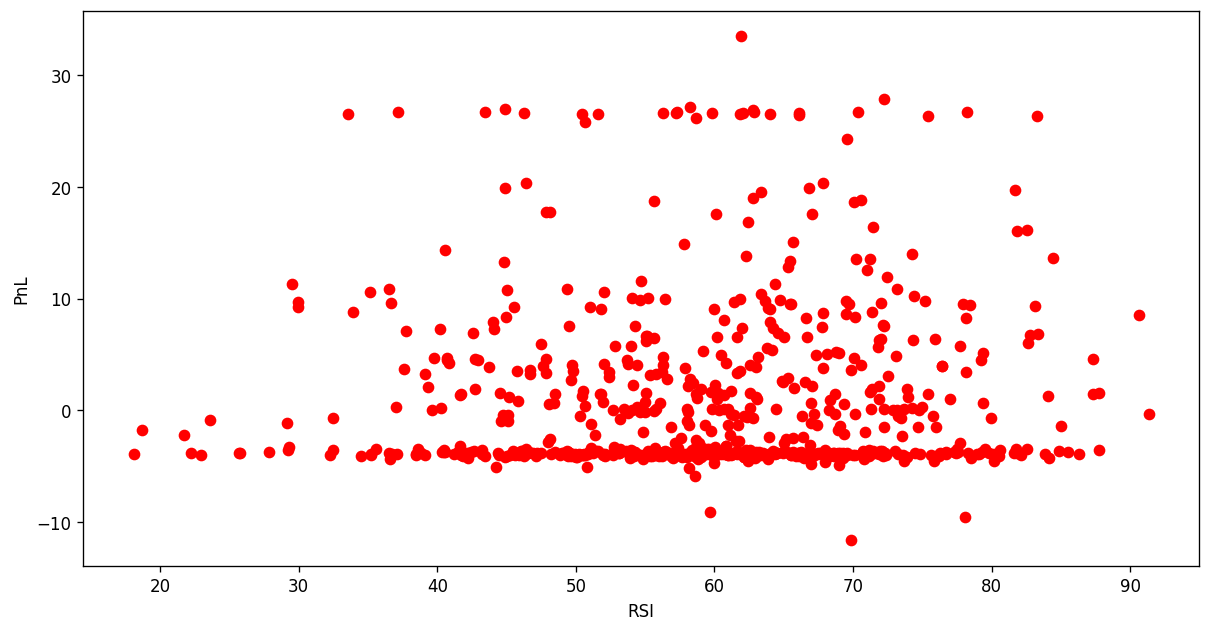

In [77]:
plt.scatter(long_trades['RSI'], long_trades['PnL'], color='red')
plt.xlabel("RSI")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

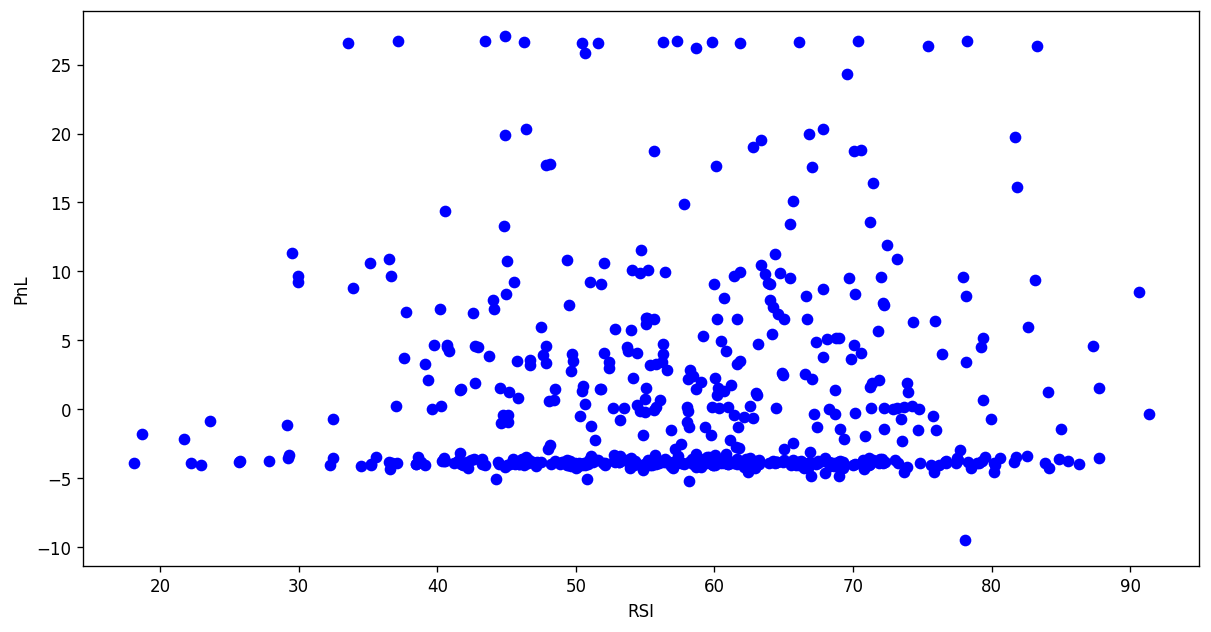

In [105]:
long_by_ema = long_trades[long_trades.ema_signal=='long']
long_by_couple_cs = long_trades[long_trades.couple_cs_signal=='long']
long_by_momentum = long_trades[long_trades.momentum_signal=='long']
# plt.scatter(long_by_ema['RSI'], long_by_ema['PnL'], color='red')
plt.scatter(long_by_couple_cs['RSI'], long_by_couple_cs['PnL'], color='blue')
# plt.scatter(long_by_momentum['RSI'], long_by_momentum['PnL'], color='green')
plt.xlabel("RSI")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

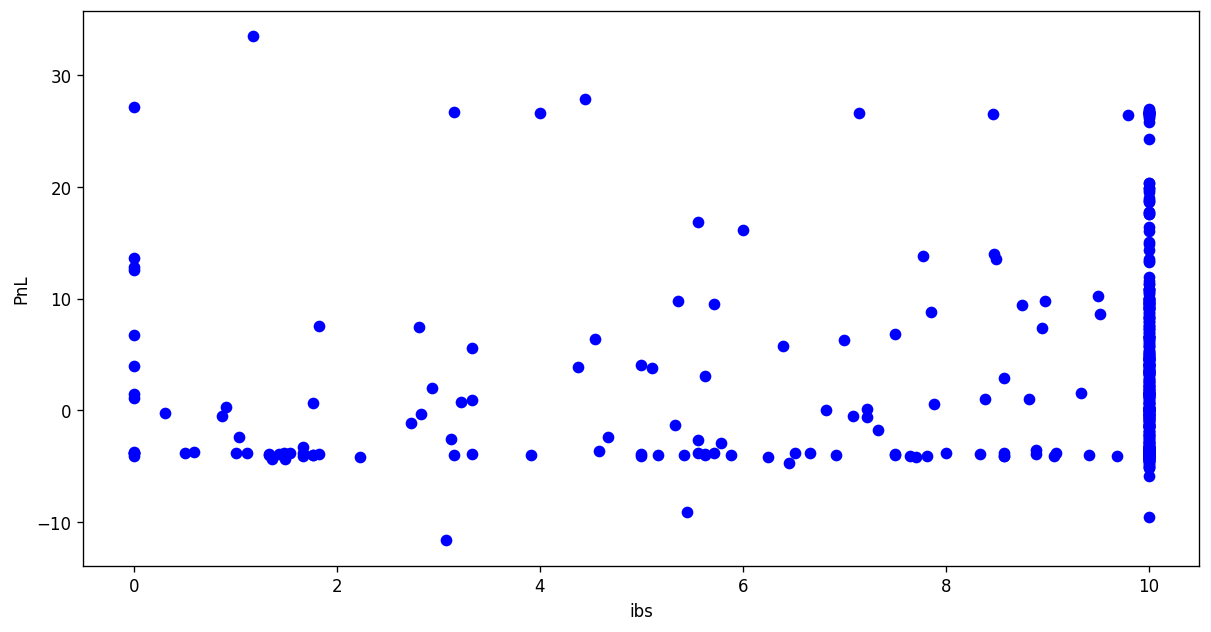

In [86]:
plt.scatter(long_trades['ibs'], long_trades['PnL'], color='blue')
plt.xlabel("ibs")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

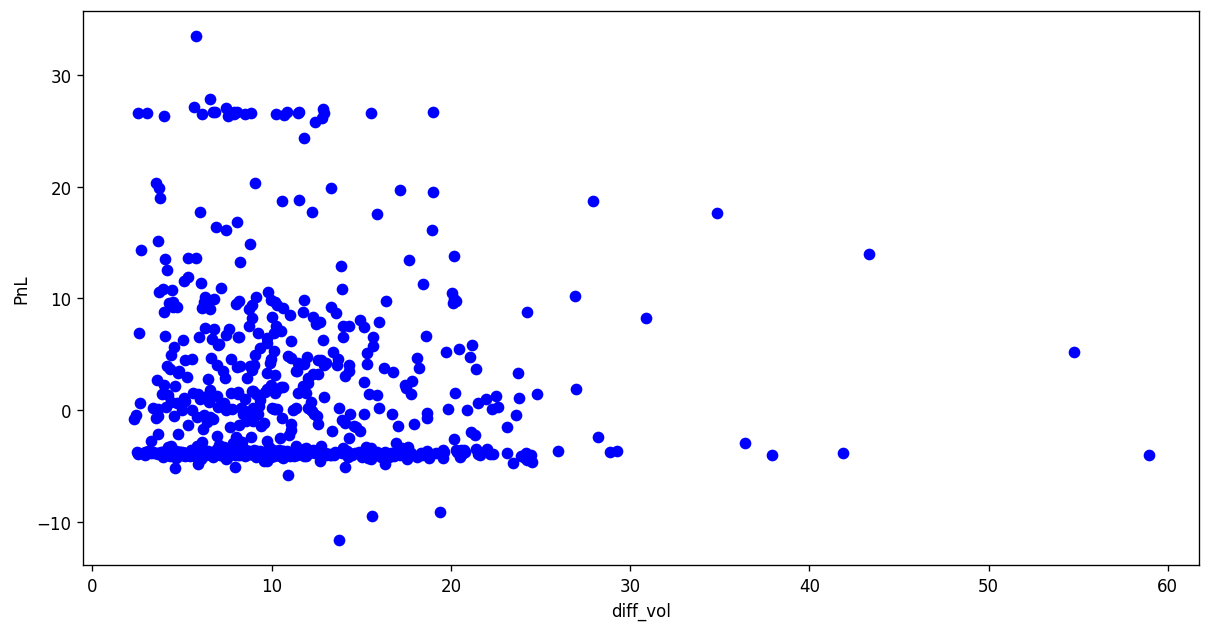

In [79]:
long_trades['diff_vol'] = 10 * long_trades['Volume'] / long_trades['vol_20_mean']
plt.scatter(long_trades['diff_vol'], long_trades['PnL'], color='blue')
plt.xlabel("diff_vol")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

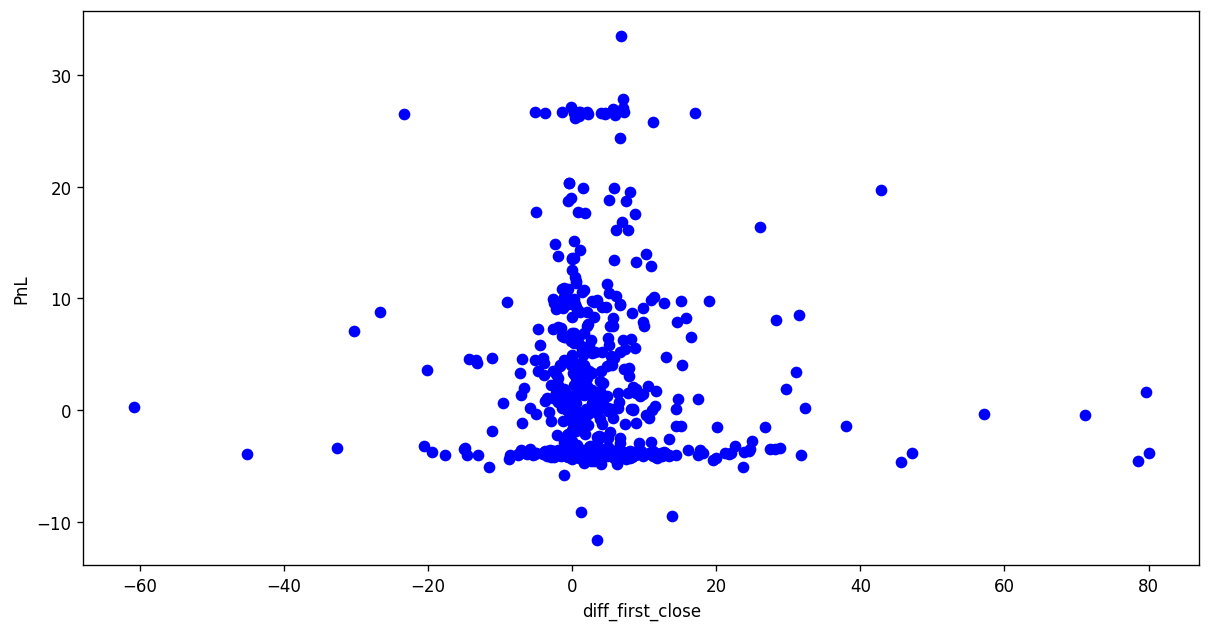

In [87]:
long_trades['diff_first_close'] = long_trades['Close'] - long_trades['first_close']
plt.scatter(long_trades['diff_first_close'], long_trades['PnL'], color='blue')
plt.xlabel("diff_first_close")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

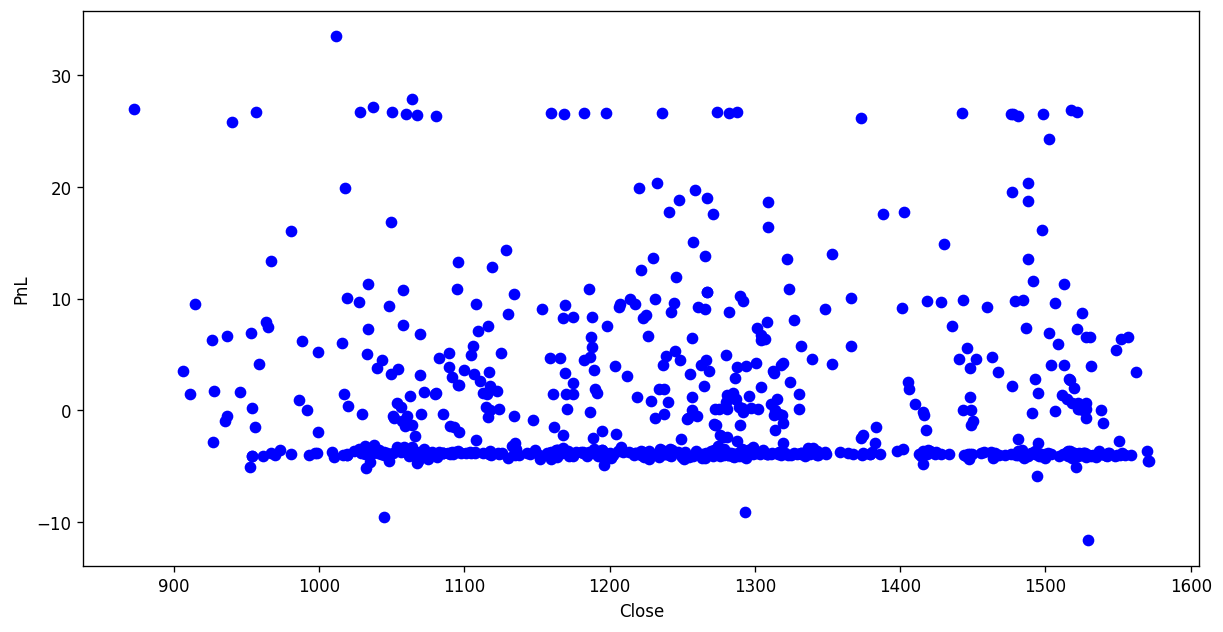

In [88]:
plt.scatter(long_trades['Close'], long_trades['PnL'], color='blue')
plt.xlabel("Close")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

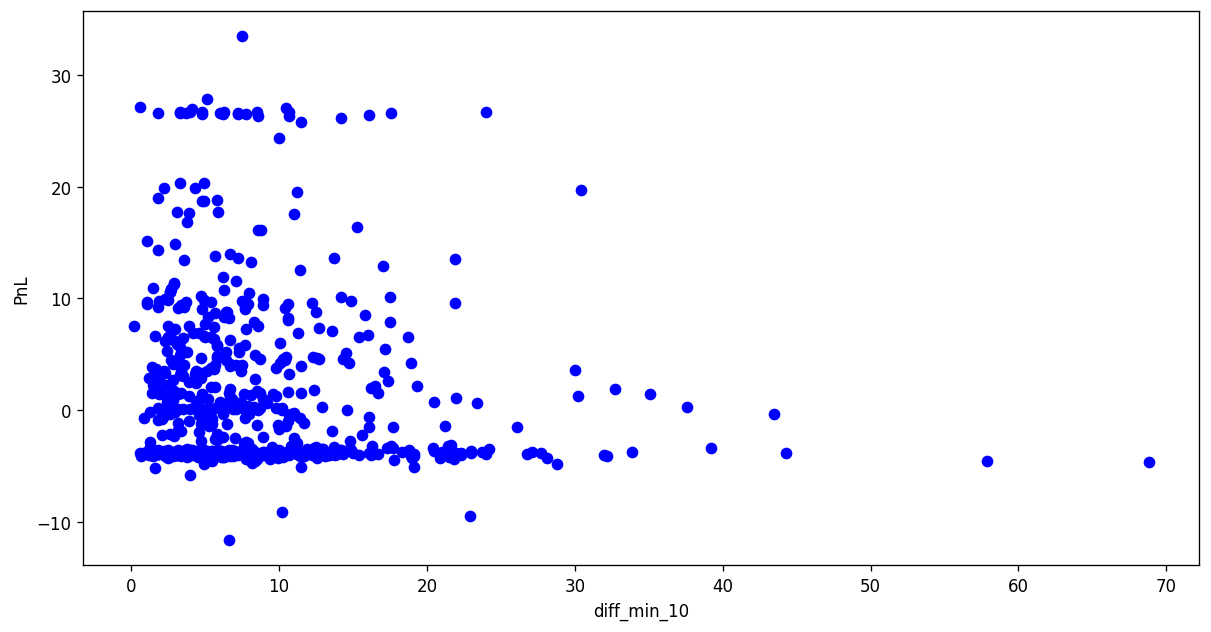

In [80]:
long_trades['diff_min_10'] = long_trades['Close'] - long_trades['min_in_range']
plt.scatter(long_trades['diff_min_10'], long_trades['PnL'], color='blue')
plt.xlabel("diff_min_10")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

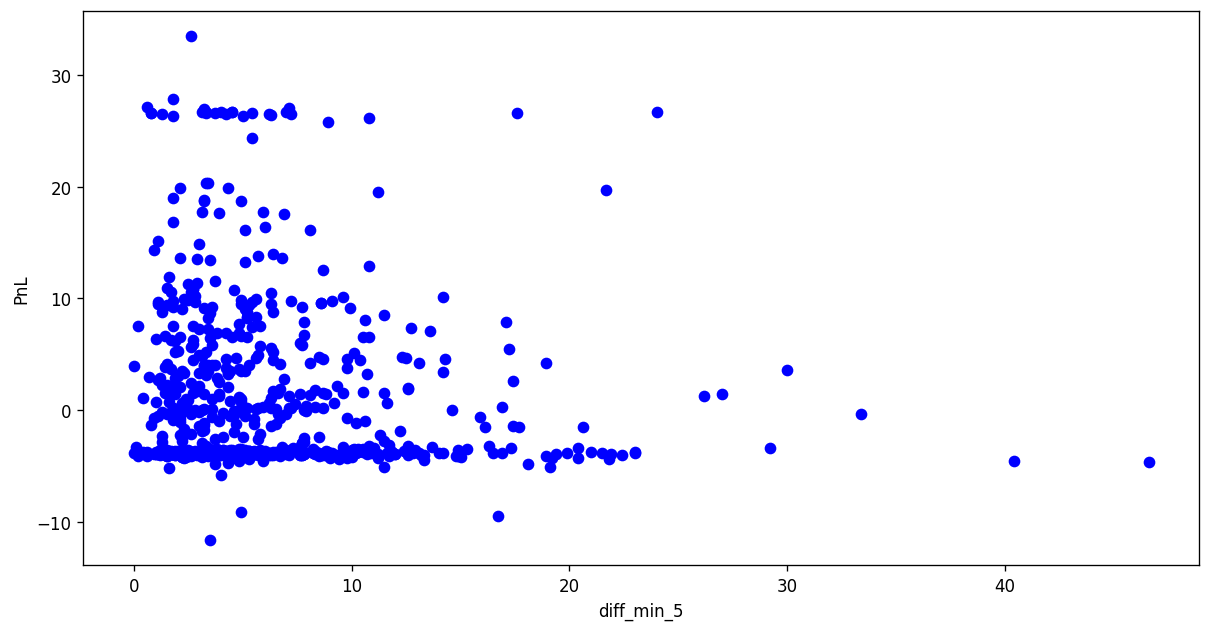

In [81]:
long_trades['diff_min_5'] = long_trades['Close'] - long_trades['min_5']
plt.scatter(long_trades['diff_min_5'], long_trades['PnL'], color='blue')
plt.xlabel("diff_min_5")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

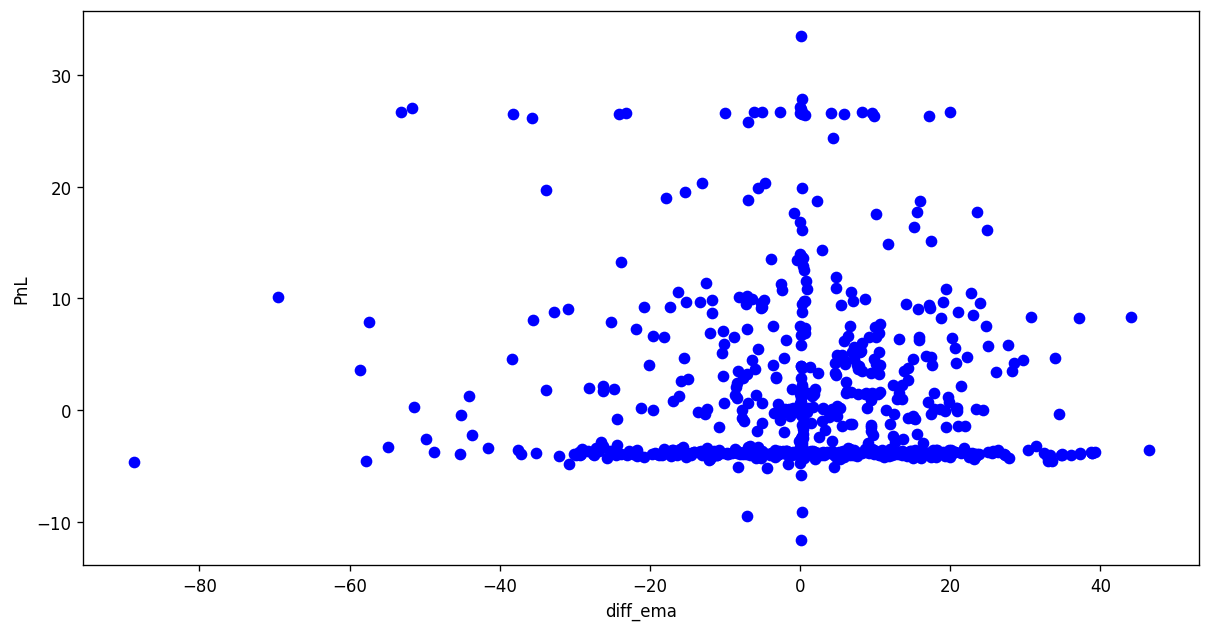

In [82]:
long_trades['diff_ema'] = long_trades['ema_fast'] - long_trades['ema_low']
plt.scatter(long_trades['diff_ema'], long_trades['PnL'], color='blue')
plt.xlabel("diff_ema")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

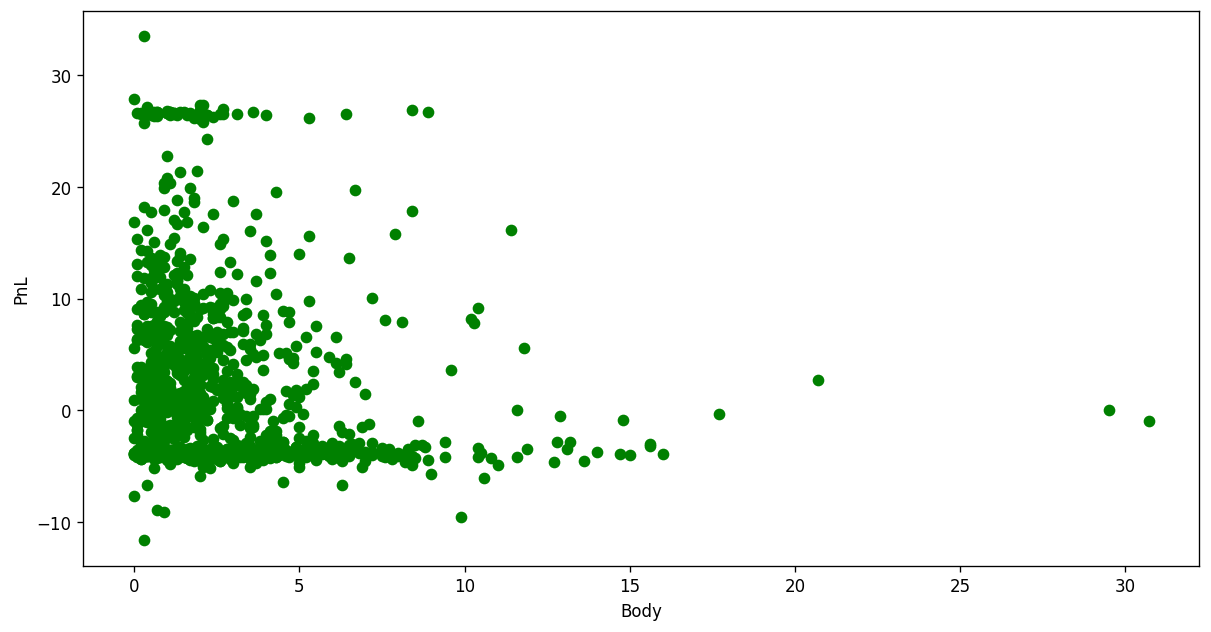

In [83]:
plt.scatter(join_trades['body'], join_trades['PnL'], color='green')
plt.xlabel("Body")
plt.ylabel("PnL")

## Optimize Take Profit

In [36]:
ema_tp_step_params = [x for x in range(5, 35)]
cs_tp_step_params = [x for x in range(5, 35)]
optimize_tp_stats, tp_heatmap = bt.optimize(ema_tp_step=ema_tp_step_params,
                                      cs_tp_step=cs_tp_step_params,
                                        maximize='Return [%]',
                                        random_state=0,
                                        return_heatmap=True)

In [37]:
optimize_tp_stats

Start                     2020-11-02 09:00:00
End                       2024-11-28 14:45:00
Duration                   1487 days 05:45:00
Exposure Time [%]                   48.476156
Equity Final [$]                   3008.34233
Equity Peak [$]                    3010.54233
Return [%]                         100.556155
Buy & Hold Return [%]                45.03944
Return (Ann.) [%]                   18.846094
Volatility (Ann.) [%]                8.121015
Sharpe Ratio                         2.320657
Sortino Ratio                        5.728444
Calmar Ratio                         4.829371
Max. Drawdown [%]                   -3.902391
Avg. Drawdown [%]                   -0.309337
Max. Drawdown Duration      109 days 03:05:00
Avg. Drawdown Duration        3 days 01:19:00
# Trades                                 1556
Win Rate [%]                        37.596401
Best Trade [%]                       3.556326
Worst Trade [%]                     -0.910953
Avg. Trade [%]                    

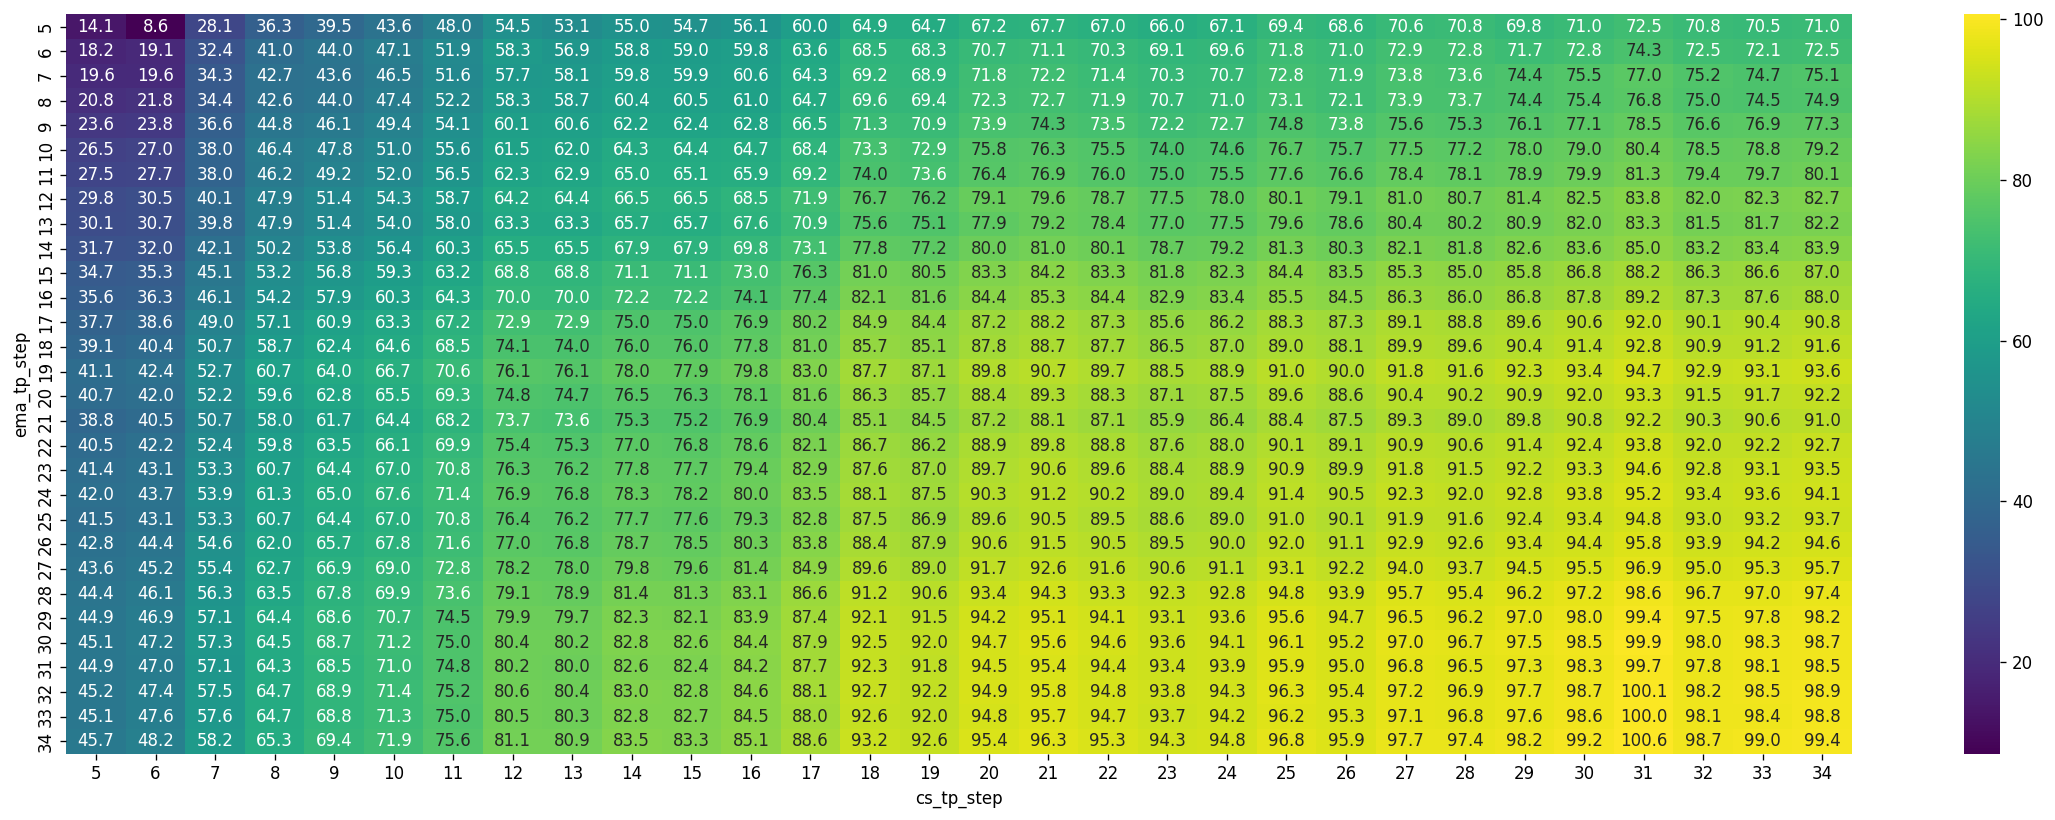

In [38]:
# Convert multiindex series to dataframe
tp_heatmap_df = tp_heatmap.unstack()
plt.figure(figsize=(24, 8))
sns.heatmap(tp_heatmap_df, annot=True, cmap='viridis', fmt='.1f')
plt.show()

## Optimize

In [283]:
ema_trailing_sl_params = [x / 10.0 for x in range(30, 100, 5)]
cs_trailing_sl_params = [x / 10.0 for x in range(25, 80, 5)]
optimize_stats, heatmap = bt.optimize(ema_trailing_sl=ema_trailing_sl_params,
                                      cs_trailing_sl=cs_trailing_sl_params,
                                        maximize='Calmar Ratio',
                                        random_state=0,
                                        return_heatmap=True)

In [284]:
optimize_stats

Start                     2020-11-02 09:00:00
End                       2024-11-26 09:05:00
Duration                   1485 days 00:05:00
Exposure Time [%]                   47.165476
Equity Final [$]                   2879.90146
Equity Peak [$]                    2885.19032
Return [%]                          91.993431
Buy & Hold Return [%]               44.228419
Return (Ann.) [%]                   17.608008
Volatility (Ann.) [%]                7.717738
Sharpe Ratio                         2.281499
Sortino Ratio                        5.278157
Calmar Ratio                         4.380319
Max. Drawdown [%]                     -4.0198
Avg. Drawdown [%]                   -0.321662
Max. Drawdown Duration      118 days 22:45:00
Avg. Drawdown Duration        3 days 04:57:00
# Trades                                 1549
Win Rate [%]                         37.50807
Best Trade [%]                       3.309918
Worst Trade [%]                     -0.762228
Avg. Trade [%]                    

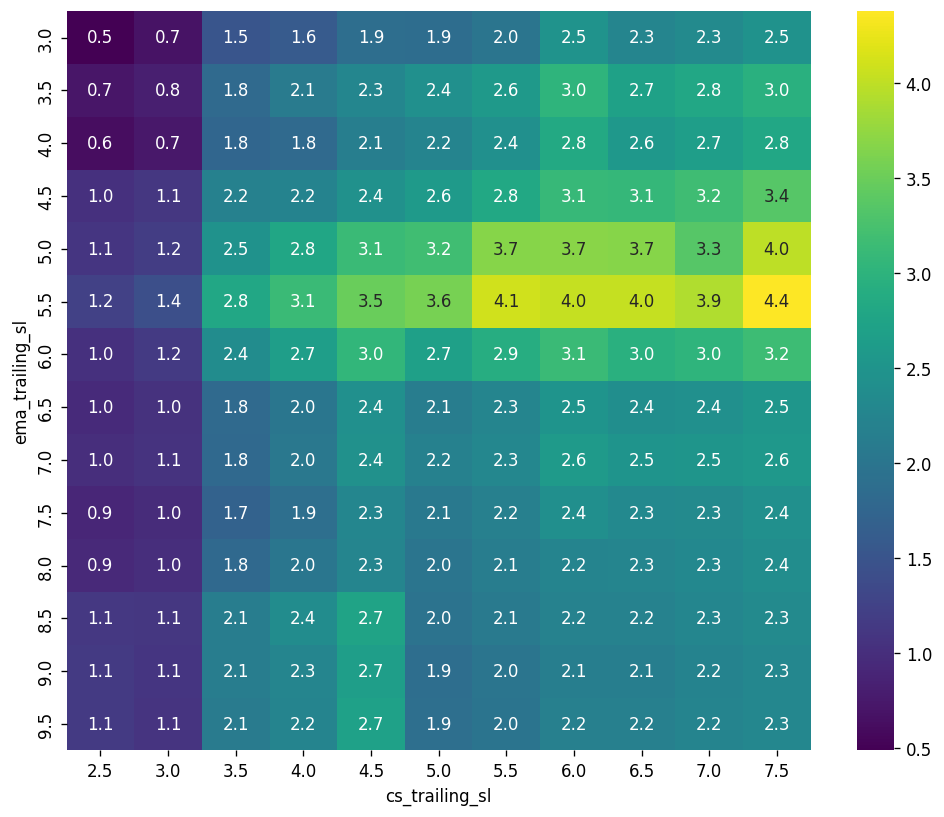

In [285]:
import seaborn as sns
# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.1f')
plt.show()